In [ ]:
import re
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from transformers import AutoTokenizer
from razdel import tokenize
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))

import warnings
warnings.filterwarnings('ignore')

<Figure size 1600x1000 with 0 Axes>

# Предисловие

В этом ноутбуке планирую обучить собственную нейронную сеть предсказывать симптомы людей по текстовому промпту. На выходе будет вектор из 22 чисел по каждому из следующих симптомов по порядку: 
- thal - результат таллиевого стресс-теста
- gluc - повышенный уровень глюкозы
- ap_lo - нижнее давление
- ap_hi - верхнее давление
- active - занимается ли физической активностью
- st_slope - наклон сегмента ST при пиковой нагрузке
- max_hr - максимальная достигнутая частота сердечных сокращений
- smoke - курит ли
- resting_bp - артериальное давление в состоянии покоя
- oldpeak - есть снижение ST сегмента электрокардиограммы вызванный физической нагрузкой
- cholesterol_int - уровень холестерина (в мг/дл)
- gender - пол
- cholesterol - повышенный ли холестерин
- fastingbs - уровень сахара в крови натощак больше 120 mg/dl
- exerciseangina - имеется стенокардия, вызванная физической нагрузкой
- restingecg - результаты электрокардиографии в состоянии покоя
- age - возраст
- alco - употребляет ли алкоголь
- cheastpaintype - боль в груди
- nummajorvessels - количество крупных сосудов , окрашенных с помощью флюороскопии
- weight - вес (кг)
- height - рост (см)

Обучу нейронную сеть с двумя предобученными эмбеддерами, сравню качество, выберу лучшую модель

## Считывание данных
Считаю данные, на которых буду обучаться, а также выполню базовую предобработку, помещу в dataloader вместе с эмбеддингами

In [ ]:
df = pd.read_csv("symptoms_prompts_generated_data.csv")

In [ ]:
# Посмотрим на данные
df[:5]

,user_prompt,thal,gluc,ap_lo,ap_hi,active,st_slope,maxhr,smoke,restingbp,...,cholesterol,fastingbs,exerciseangina,restingecg,age,alco,cheastpaintype,nummajorvessels,weight,height
0,"Я постоянно ощущаю сильное давление в груди, о...",1.0,1.0,131.0,226.0,1.0,1.0,154.0,0.0,79.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Меня беспокоит очень высокое давление в покое ...,2.0,0.0,NaN,NaN,NaN,NaN,75.0,NaN,195.0,...,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,"Мне 56 лет, жалуюсь на постоянную усталость и ...",NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,NaN,NaN,NaN,NaN,NaN
3,У меня очень высокий уровень холестерина — 383...,NaN,NaN,104.0,216.0,NaN,NaN,NaN,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,0.0,2.0,1.0,NaN,NaN
4,"Я чувствую сильную головную боль и бессонницу,...",NaN,NaN,NaN,223.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9130 entries, 0 to 9129
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_prompt      9130 non-null   object 
 1   thal             3435 non-null   float64
 2   gluc             3466 non-null   float64
 3   ap_lo            3468 non-null   float64
 4   ap_hi            3364 non-null   float64
 5   active           3428 non-null   float64
 6   st_slope         3446 non-null   float64
 7   maxhr            3364 non-null   float64
 8   smoke            3399 non-null   float64
 9   restingbp        3431 non-null   float64
 10  oldpeak          3480 non-null   float64
 11  cholesterol_int  3482 non-null   float64
 12  gender           3452 non-null   float64
 13  cholesterol      3439 non-null   float64
 14  fastingbs        3404 non-null   float64
 15  exerciseangina   3401 non-null   float64
 16  restingecg       3410 non-null   float64
 17  age           

В данных треть от каждой фичи это пропущенные значения. Это стоит учитывать при обучении модели.

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

## 1. DeepPavlov tokenizer

Первым протестирую токенизатор DeepPavlov, загруженный из huggingface. Этот токенизатор идет вместе с bert моделью, обученной на корпусе из предложений на русском языке. С помощью него будем вытаскивать токены в предложениях и превращать их в эмбеддинги на лету во время обучения.

In [ ]:
# Загрузим токенизатор и определим функцию, возвращающая список из токенов
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
def tokenize_dp(text):
    return tokenizer.encode_plus(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )['input_ids'].squeeze(0)

Определим максимальную длину предложений из токенов. Эту длину будем использовать в архитектуре нейросети.

In [ ]:
max_length = 0
for txt in df['user_prompt']:
    if len(tokenizer(txt)['input_ids']) > max_length:
        max_length = len(tokenizer(txt)['input_ids'])

In [56]:
max_length

375

Определим класс кастомного датасета. Этот датасет будет формировать токенизированное предложение, а также вектор ответов и вектор маски непропущенных значений, чтобы нейросеть не обращала на них внимания. В векторе из ответов все вещественные признаки нормализуются во избежание большого разброса.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, numerical_ranges):
        self.df = df.reset_index().copy()
        self.texts = df['user_prompt'].apply(lambda x: tokenize_dp(x)).tolist()
        
        # Нормализация числовых признаков
        self.targets = df.copy()
        for name, (min_val, max_val) in numerical_ranges.items():
            if name in self.targets.columns:
                self.targets[name] = (self.targets[name] - min_val) / (max_val - min_val)
                
        self.targets = self.targets.iloc[:, 1:].values
        self.masks = ~df.iloc[:, 1:].isna().values

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts[idx],
            'targets': torch.FloatTensor(self.targets[idx]),
            'mask': torch.FloatTensor(self.masks[idx])
        }

    def __len__(self):
        return len(self.targets)

In [ ]:
# Определю словарь из вещественных признаков
# и диапазон возможных значений по каждому признаку
numerical_ranges = {
    'ap_lo': (40, 150),
    'ap_hi': (60, 240),
    'max_hr': (70, 240),
    'resting_bp': (70, 230),
    'cholesterol_int': (126, 565),
    'age': (18, 101),
    'nummajorvessels': (0, 5),
    'weight': (40, 201),
    'height': (150, 221)
}

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, numerical_ranges)
val_dataset = CustomDataset(val_df, tokenizer, numerical_ranges)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

## Построение нейросети

Здесь определю основные переменные, которые подаются на вход нейросети. В переменная output_config находится 22 элемента - обозначение по каждому признаку, является ли он вещественным или категориальным, и если категориальный, то сколько возможных значений он содержит.<br>
Стратегия обучения нейросети следующая: категориальные фичи будут обучаться на CrossEntropyLoss, а вещественные фичи на MSELoss по отдельности. В итоге мы сможем предсказывать с помощью функции argmax категориальные признаки, а вещественные - это будут логиты модели.

In [ ]:
vocab_size = tokenizer.vocab_size 
embedding_dim = max_length
hidden_dim = 512
output_config = [
    ('thal', 'categorical', 4),
    ('gluc', 'categorical', 2),
    ('ap_lo', 'numerical', 1),
    ('ap_hi', 'numerical', 1),
    ('active', 'categorical', 2),
    ('st_slope', 'categorical', 3),
    ('max_hr', 'numerical', 1),
    ('smoke', 'categorical', 2),
    ('resting_bp', 'numerical', 1),
    ('oldpeak', 'categorical', 2),
    ('cholesterol_int', 'numerical', 1),
    ('gender', 'categorical', 2),
    ('cholesterol', 'categorical', 2),
    ('fastingbs', 'categorical', 2),
    ('exerciseangina', 'categorical', 2),
    ('restingecg', 'categorical', 3),
    ('age', 'numerical', 1),
    ('alco', 'categorical', 2),
    ('cheastpaintype', 'categorical', 4),
    ('nummajorvessels', 'numerical', 1),
    ('weight', 'numerical', 1),
    ('height', 'numerical', 1)
]

In [ ]:
class MultiOutputModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_config, vocab_size=None):
        super().__init__()
        # Здесь и далее я учитываю, что vocab_size у нас может не быть,
        # так как будем подавать сразу эмбеддинги вместо порядковых чисел токенов
        self.vocab_size = vocab_size
        if vocab_size:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2*hidden_dim, 512)
        
        # Выходные слои для каждого признака
        self.heads = nn.ModuleDict()
        for idx, (name, type_, num_classes) in enumerate(output_config):
            if type_ == 'categorical':
                self.heads[f'head_{idx}'] = nn.Linear(512, num_classes)
            elif type_ == 'numerical':
                self.heads[f'head_{idx}'] = nn.Sequential(
                    nn.Linear(512, 1),
                    nn.Sigmoid()
                )

    def forward(self, x):
        if self.vocab_size:
            x = self.embedding(x)
        x, _ = self.rnn(x)
        if self.vocab_size:
            x = torch.mean(x, dim=1)
        x = torch.relu(self.fc(x))
        
        outputs = []
        for head in self.heads.values():
            outputs.append(head(x))
        return torch.cat(outputs, dim=1)

## Вспомогательные функции для логирования обучения

Напишу функции для расчета потерь (лоссы будут отдельно считаться для категориальных и вещественных фичей, затем складываться в общий лосс) и метрик (буду использовать две метрики: f1 для категориальных фичей и mae для вещественных), а также основной скрипт обучения.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def compute_loss(outputs, targets, masks, output_config):
    total_loss = 0
    start_idx = 0
    
    for idx, (_, type_, num_classes) in enumerate(output_config):
        mask = masks[:, idx]
        valid = mask == 1
        
        if type_ == 'categorical':
            loss_fn = nn.CrossEntropyLoss()
            pred = outputs[:, start_idx:start_idx+num_classes]
            loss = loss_fn(pred[valid], targets[valid, idx].long())
        else:
            loss_fn = nn.MSELoss()
            pred = outputs[:, start_idx]
            loss = loss_fn(pred[valid], targets[valid, idx])
            
        total_loss += loss
        start_idx += num_classes if type_ == 'categorical' else 1
    
    return total_loss / len(output_config)

In [ ]:
def compute_metrics(outputs, targets, masks, output_config):
    metrics = {'f1': 0, 'mae': 0}
    start_idx = 0
    total_counts = {'categorical': 0, 'numerical': 0}
    
    for idx, (_, type_, num_classes) in enumerate(output_config):
        mask = masks[:, idx]
        valid = mask == 1
        
        if not valid.any():
            start_idx += num_classes if type_ == 'categorical' else 1
            continue
            
        if type_ == 'categorical':
            preds = torch.argmax(outputs[:, start_idx:start_idx+num_classes], dim=1)
            f1 = f1_score(targets[valid, idx].cpu().numpy(), 
                         preds[valid].cpu().numpy(), average='weighted')
            metrics['f1'] += f1
            total_counts['categorical'] += 1
            
        else:
            preds = outputs[:, start_idx]
            mae = torch.abs(preds[valid] - targets[valid, idx]).mean().item()
            metrics['mae'] += mae
            total_counts['numerical'] += 1
            
        start_idx += num_classes if type_ == 'categorical' else 1
    
    # Нормализация метрик
    if total_counts['categorical'] > 0:
        metrics['f1'] /= total_counts['categorical']
    if total_counts['numerical'] > 0:
        metrics['mae'] /= total_counts['numerical']
    
    return metrics

In [ ]:
def train_model(model, train_loader, val_loader, output_config, epochs):
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_f1': [],
        'train_mae': [],
        'val_f1': [],
        'val_mae': []
    }
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        train_metrics = {'f1': 0, 'mae': 0}
        
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            targets = batch['targets'].to(device)
            mask = batch['mask'].to(device)
            
            outputs = model(input_ids)
            loss = compute_loss(outputs, targets, mask, output_config)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            metrics = compute_metrics(outputs.cpu(), targets.cpu(), mask.cpu(), output_config)
            train_metrics['f1'] += metrics['f1']
            train_metrics['mae'] += metrics['mae']
        
        model.eval()
        epoch_val_loss = 0
        val_metrics = {'f1': 0, 'mae': 0}
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                input_ids = batch['input_ids'].to(device)
                targets = batch['targets'].to(device)
                mask = batch['mask'].to(device)
                
                outputs = model(input_ids)
                loss = compute_loss(outputs, targets, mask, output_config)
                epoch_val_loss += loss.item()
                
                metrics = compute_metrics(outputs.cpu(), targets.cpu(), mask.cpu(), output_config)
                val_metrics['f1'] += metrics['f1']
                val_metrics['mae'] += metrics['mae']
        
        # Добавление логов
        history['train_loss'].append(epoch_train_loss / len(train_loader))
        history['val_loss'].append(epoch_val_loss / len(val_loader))
        
        history['train_f1'].append(train_metrics['f1'] / len(train_loader))
        history['train_mae'].append(train_metrics['mae'] / len(train_loader))
        
        history['val_f1'].append(val_metrics['f1'] / len(val_loader))
        history['val_mae'].append(val_metrics['mae'] / len(val_loader))
        
        # логирую каждую 5-ю эпоху
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}")
            print(f"Train F1: {history['train_f1'][-1]:.4f} | Val F1: {history['val_f1'][-1]:.4f}")
            print(f"Train MAE: {history['train_mae'][-1]:.4f} | Val MAE: {history['val_mae'][-1]:.4f}")
            print("---------------------------------------------------")
    
    return history

In [ ]:
model = MultiOutputModel(embedding_dim, hidden_dim, output_config, vocab_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
history_deeppavlov = train_model(model, train_loader, val_loader, output_config, numerical_ranges, epochs=20)

100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch 1/20
Train Loss: 2259.3324 | Val Loss: 2229.2147
Train F1: 0.2800 | Val F1: 0.2799
Train MAE: 33.5774 | Val MAE: 33.3548
---------------------------------------------------


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch 6/20
Train Loss: 2263.1124 | Val Loss: 2229.1572
Train F1: 0.4649 | Val F1: 0.4781
Train MAE: 33.6002 | Val MAE: 33.3508
---------------------------------------------------


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Epoch 11/20
Train Loss: 2258.1417 | Val Loss: 2229.0436
Train F1: 0.6749 | Val F1: 0.6677
Train MAE: 33.5614 | Val MAE: 33.3502
---------------------------------------------------


100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


Epoch 16/20
Train Loss: nan | Val Loss: 2228.9653
Train F1: 0.8138 | Val F1: 0.7588
Train MAE: 33.7752 | Val MAE: 33.3516
---------------------------------------------------


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Видим, что лосс никак не падает. Метрика mae не меняется, а вот f1 растет неплохо. Сохраню модель.

In [ ]:
torch.save(model, "model_deeppavlov_tokens.pt")

## 2. razdel tokenization + paraphrase-multilingual-MiniLM-L12-v2 embeddings

Вторым вариантом я выберу разделение предложения на токены с помощью библиотеки razdel, которая хорошо токенизирует русские предложения. Затем подам каждый токен в paraphrase-multilingual-MiniLM-L12-v2 модель, которая находит эмбеддинги размера 384, и усредню эмбеддинги по каждому токену.

In [ ]:
model_embed = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [ ]:
def embedder(text):
    # Токенизирую предложения, удаляю мусорные символы, нахожу эмбеддинги
    tokens = [s.text for s in tokenize(text)]
    tokens = [re.sub(r'[^\w]', '', token) for token in tokens]
    tokens = [token for token in tokens if token] 
    return model_embed.encode(tokens, show_progress_bar=False).mean(axis=0)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, numerical_ranges):
        self.df = df.reset_index().copy()
        self.texts = df['user_prompt'].apply(embedder).to_list()
        
        self.targets = df.copy()
        for name, (min_val, max_val) in numerical_ranges.items():
            if name in self.targets.columns:
                self.targets[name] = (self.targets[name] - min_val) / (max_val - min_val)
                
        self.targets = self.targets.iloc[:, 1:].values
        self.masks = ~df.iloc[:, 1:].isna().values

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts[idx],
            'targets': torch.FloatTensor(self.targets[idx]),
            'mask': torch.FloatTensor(self.masks[idx])
        }

    def __len__(self):
        return len(self.targets)

In [ ]:
train_dataset = CustomDataset(train_df, numerical_ranges)
val_dataset = CustomDataset(val_df, numerical_ranges)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

## Обучение модели

Здесь уже эмбеддинги подаются на вход модели сразу, поэтому vocab_size и слой nn.Embeddings нам не нужны

In [ ]:
embedding_dim = 384
model = MultiOutputModel(embedding_dim, hidden_dim, output_config)
history_razdel = train_model(model, train_loader, val_loader, output_config, numerical_ranges, epochs=101)

100%|██████████| 29/29 [00:01<00:00, 24.55it/s]


Epoch 1/101
Train Loss: 2269.8119 | Val Loss: 2229.2065
Train F1: 0.2826 | Val F1: 0.2770
Train MAE: 33.6620 | Val MAE: 33.3538
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.63it/s]


Epoch 6/101
Train Loss: 2266.5742 | Val Loss: 2229.1887
Train F1: 0.2893 | Val F1: 0.2753
Train MAE: 33.6337 | Val MAE: 33.3509
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.46it/s]


Epoch 11/101
Train Loss: nan | Val Loss: 2229.1819
Train F1: 0.3460 | Val F1: 0.3454
Train MAE: 33.7120 | Val MAE: 33.3504
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 22.50it/s]


Epoch 16/101
Train Loss: 2272.7314 | Val Loss: 2229.1703
Train F1: 0.4491 | Val F1: 0.4366
Train MAE: 33.6766 | Val MAE: 33.3506
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.50it/s]


Epoch 21/101
Train Loss: nan | Val Loss: 2229.1371
Train F1: 0.5435 | Val F1: 0.5199
Train MAE: 33.5936 | Val MAE: 33.3508
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.94it/s]


Epoch 26/101
Train Loss: 2268.1577 | Val Loss: 2229.1144
Train F1: 0.5770 | Val F1: 0.5608
Train MAE: 33.6502 | Val MAE: 33.3500
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.78it/s]


Epoch 31/101
Train Loss: 2270.4306 | Val Loss: 2229.1130
Train F1: 0.5903 | Val F1: 0.5599
Train MAE: 33.6503 | Val MAE: 33.3502
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.55it/s]


Epoch 36/101
Train Loss: 2276.9526 | Val Loss: 2229.1073
Train F1: 0.6065 | Val F1: 0.5853
Train MAE: 33.7076 | Val MAE: 33.3505
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.83it/s]


Epoch 41/101
Train Loss: 2274.5748 | Val Loss: 2229.0904
Train F1: 0.6177 | Val F1: 0.6102
Train MAE: 33.6937 | Val MAE: 33.3494
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.89it/s]


Epoch 46/101
Train Loss: 2275.2681 | Val Loss: 2229.0881
Train F1: 0.6358 | Val F1: 0.6092
Train MAE: 33.6870 | Val MAE: 33.3499
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.63it/s]


Epoch 51/101
Train Loss: 2272.5723 | Val Loss: 2229.0778
Train F1: 0.6437 | Val F1: 0.6206
Train MAE: 33.6747 | Val MAE: 33.3494
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.27it/s]


Epoch 56/101
Train Loss: nan | Val Loss: 2229.0740
Train F1: 0.6530 | Val F1: 0.6389
Train MAE: 33.6111 | Val MAE: 33.3490
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.90it/s]


Epoch 61/101
Train Loss: nan | Val Loss: 2229.0744
Train F1: 0.6637 | Val F1: 0.6363
Train MAE: 33.6255 | Val MAE: 33.3486
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.47it/s]


Epoch 66/101
Train Loss: 2269.0669 | Val Loss: 2229.0637
Train F1: 0.6696 | Val F1: 0.6492
Train MAE: 33.6338 | Val MAE: 33.3479
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.07it/s]


Epoch 71/101
Train Loss: 2270.5044 | Val Loss: 2229.0626
Train F1: 0.6788 | Val F1: 0.6595
Train MAE: 33.6573 | Val MAE: 33.3477
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.72it/s]


Epoch 76/101
Train Loss: nan | Val Loss: 2229.0597
Train F1: 0.6846 | Val F1: 0.6544
Train MAE: 33.6211 | Val MAE: 33.3469
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.15it/s]


Epoch 81/101
Train Loss: 2267.4377 | Val Loss: 2229.0544
Train F1: 0.6934 | Val F1: 0.6663
Train MAE: 33.6294 | Val MAE: 33.3465
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.49it/s]


Epoch 86/101
Train Loss: 2276.6483 | Val Loss: 2229.0562
Train F1: 0.7007 | Val F1: 0.6651
Train MAE: 33.6912 | Val MAE: 33.3468
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.43it/s]


Epoch 91/101
Train Loss: 2264.1139 | Val Loss: 2229.0564
Train F1: 0.7066 | Val F1: 0.6682
Train MAE: 33.5893 | Val MAE: 33.3457
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 24.59it/s]


Epoch 96/101
Train Loss: 2270.2354 | Val Loss: 2229.0500
Train F1: 0.7162 | Val F1: 0.6686
Train MAE: 33.6509 | Val MAE: 33.3456
---------------------------------------------------


100%|██████████| 29/29 [00:01<00:00, 25.41it/s]

Epoch 101/101
Train Loss: 2270.0900 | Val Loss: 2229.0466
Train F1: 0.7191 | Val F1: 0.6730
Train MAE: 33.6539 | Val MAE: 33.3443
---------------------------------------------------


По результатам обучения видим, что с вещественными признаками ситуация не улучшилась, а по категориальным метрика также растет. <br>
Выберу версию с deeppavlov, так как там метрика f1 выше.

## Визуализация логов обучения

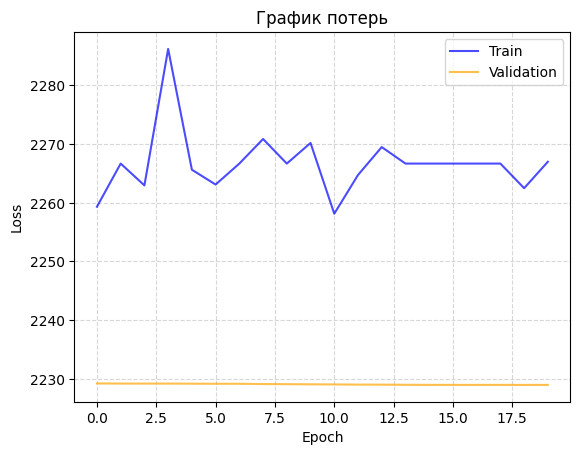

In [ ]:
# Заменяю пропущенные значения на средние
for key in history_deeppavlov:
    history_deeppavlov[key] = np.array(history_deeppavlov[key])
    if key.startswith('train'):
        history_deeppavlov[key][np.isnan(history_deeppavlov[key])] = np.nanmean(history_deeppavlov[key])

plt.plot(history_deeppavlov['train_loss'], label='Train', color='blue', alpha=0.7)
plt.plot(history_deeppavlov['val_loss'], label='Validation', color='orange', alpha=0.7)
plt.title('График потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

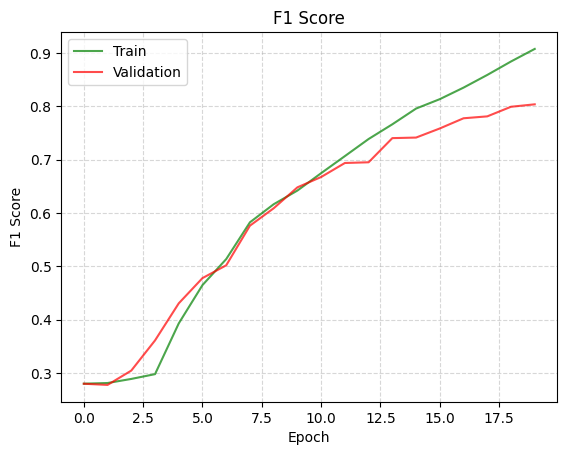

In [ ]:
plt.plot(history_deeppavlov['train_f1'], label='Train', color='green', alpha=0.7)
plt.plot(history_deeppavlov['val_f1'], label='Validation', color='red', alpha=0.7)
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

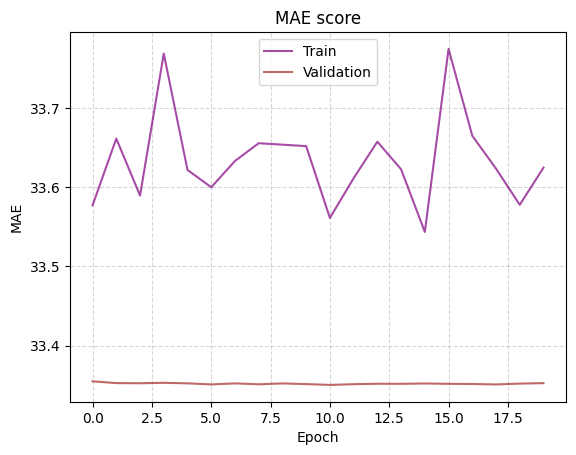

In [ ]:
plt.plot(history_deeppavlov['train_mae'], label='Train', color='purple', alpha=0.7)
plt.plot(history_deeppavlov['val_mae'], label='Validation', color='brown', alpha=0.7)
plt.title('MAE score')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## Инференс модели

Реализую код для использования модели на инференсе

In [ ]:
model = torch.load('model_deeppavlov_tokens.pt', map_location=device)

In [ ]:
def predict(text, model, output_config, numerical_ranges):
    model.eval()
    with torch.no_grad():
        inputs = tokenize_dp(text).unsqueeze(0).to(device)
        outputs = model(inputs).squeeze(0).cpu()
    
    prediction = []
    start_idx = 0
    
    for idx, (name, type_, num_classes) in enumerate(output_config):
        if type_ == 'categorical':
            probs = torch.softmax(outputs[start_idx:start_idx+num_classes], -1)
            if torch.max(probs) < 0.5:  # Порог уверенности
                prediction.append(torch.nan)
            else:
                prediction.append(torch.argmax(probs).item())
            start_idx += num_classes
        else:
            min_val, max_val = numerical_ranges[name]
            val = outputs[start_idx].item() * (max_val - min_val) + min_val
            prediction.append(val)
            start_idx += 1
    
    return torch.tensor(prediction)

In [ ]:
text = "Я мужчина постоянно ощущаю сильное давление в груди, особенно во время физической активности. \
    У меня также есть подозрения на проблемы с сердцем, так как результаты стресс-теста показывают фиксированный дефект. \
        На днях я заметила, что уровень глюкозы в крови значительно повышен, что меня очень беспокоит. \
            Особенно тревожит, что артериальное давление зашкаливает: верхнее 226, а нижнее 131. \
                Несмотря на то что стараюсь поддерживать физическую активность, по последнему тесту заметила, \
                    что максимальная частота сердечных сокращений достигала лишь 154. Никаких изменений в состоянии покоя не наблюдала: \
                        давление 79. При этом сегмент ST на электрокардиограмме не меняется при физических нагрузках, но к чему это может привести? \
                            И еще момент: уровень холестерина меня просто шокирует – 513, хотя у меня его не считали повышенным. В целом, \
                                такая ситуация меня пугает, я не курю и стараюсь следить за своим здоровьем, но чувствую, что не все в порядке."

In [54]:
pred = predict(text, model, output_config, numerical_ranges)

In [53]:
symptoms = ['thal', 'gluc', 'ap_lo', 'ap_hi', 'active', 'st_slope', 
            'max_hr', 'smoke', 'resting_bp', 'oldpeak', 'cholesterol_int', 
            'gender', 'cholesterol', 'fastingbs', 'exerciseangina', 
            'restingecg', 'age', 'alco', 'cheastpaintype', 'nummajorvessels', 
            'weight', 'height' ]

In [55]:
for sym, val in zip(symptoms, pred):
    print(f"{sym}: {val}")

thal: 1.0
gluc: 1.0
ap_lo: 87.1370849609375
ap_hi: 150.93275451660156
active: 1.0
st_slope: 2.0
max_hr: 240.0
smoke: 0.0
resting_bp: 230.0
oldpeak: 0.0
cholesterol_int: 372.85345458984375
gender: 1.0
cholesterol: 0.0
fastingbs: 0.0
exerciseangina: 0.0
restingecg: 0.0
age: 54.28721618652344
alco: 0.0
cheastpaintype: nan
nummajorvessels: 1.7663443088531494
weight: 101.04859161376953
height: 187.79180908203125


Выводы и дальнейшие шаги:<br>
С текущей реалищацией нейронная сеть довольно плохо предсказывает вещественные признаки и хорошо справляется с категориальными. Думаю, чтобы модель умела вытягивать числа из текста, нужно отдельно их вытаскивать из голого промпта и обучать еще одну голову, где будет храниться информация о численных значениях, которые вводит человек в тексте. 